In [1]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import matplotlib
import pylab as pl
from scipy.fftpack import rfft
import aifc
from IPython.display import Image
from PIL import Image
from keras.callbacks import ModelCheckpoint

2023-02-24 17:37:13.407240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Watch train data

In [2]:
df = pd.read_csv('../data/data/train.csv')
print(df.head(-5))

             clip_name  label
0          train1.aiff      0
1          train2.aiff      0
2          train3.aiff      0
3          train4.aiff      0
4          train5.aiff      0
...                ...    ...
29990  train29991.aiff      1
29991  train29992.aiff      1
29992  train29993.aiff      0
29993  train29994.aiff      0
29994  train29995.aiff      0

[29995 rows x 2 columns]


Let's try to plot a simple spectrogram

In [3]:
def PlotSpecgram(P, freqs, bins):
    """Spectrogram"""
    Z = np.flipud(P) # flip rows so that top goes to bottom, bottom to top, etc.
    xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    extent = xmin, xmax, freqs[0], freqs[-1]

    im = pl.imshow(Z, extent=extent)
    pl.axis('auto')
    pl.xlim([0.0, bins[-1]])
    pl.ylim([0, 1000])

In [4]:
whale_sample_file = '../data/data/train/train1.aiff'
whale_aiff = aifc.open(whale_sample_file,'r')
print("Channels:", whale_aiff.getnchannels()) 
print("Frames:", whale_aiff.getnframes())
print("Frame rate (frames per second):", whale_aiff.getframerate())

Channels: 1
Frames: 4000
Frame rate (frames per second): 2000


/var/folders/88/c0pdndcx27s58d3c8hwgyz700000gn/T/ipykernel_12616/726627918.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  whale_array = np.fromstring(whale_strSig, np.short).byteswap()


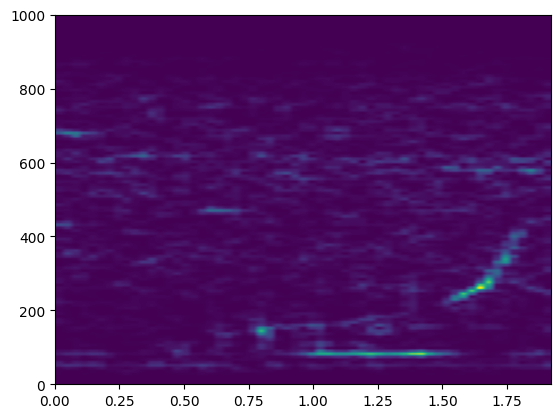

In [5]:
whale_strSig = whale_aiff.readframes(whale_aiff.getnframes())
whale_array = np.fromstring(whale_strSig, np.short).byteswap()
params = {'NFFT':256, 'Fs':2000, 'noverlap':192}
P, freqs, bins = mlab.specgram(whale_array, **params)
img = PlotSpecgram(P, freqs, bins)

(129, 59)

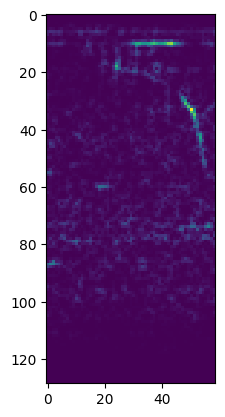

In [6]:
plt.imshow(P, interpolation='nearest')
P.shape

In [8]:
spect_zeros = np.zeros((129, 20))
# new_spect = np.concatenate((spect_zeros, P), axis=1)
# new_spect = np.concatenate((spect_zeros, P), axis=1)

In [87]:
# new_spect.shape

# new_spect *= 85.0/new_spect.max()

# Normalised [0,255] as integer: don't forget the parenthesis before astype(int)
# new_spect = (20.*(new_spect - np.min(new_spect))/np.ptp(new_spect))
# new_spect = 2.*(new_spect - np.min(new_spect))/np.ptp(new_spect)-1

# for i in range(len(new_spect)):
#     print(new_spect[i])

In [9]:
# img = np.zeros((129, 79, 3))
# img[:,:,0] = new_spect
# img[:,:,1] = new_spect
# img[:,:,2] = new_spect

# image = Image.fromarray(P, mode="L")
# # image.thumbnail((400, 400))
# image.save("test.jpg")
# print(image.mode)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


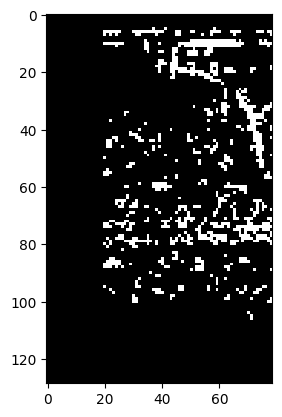

In [64]:
plt.imshow(img, interpolation='nearest')

Now we can plot and recognize others spectrograms and add a target for each of them

In [10]:
# Set path to directory with folders train and test
path_data = '../data/data/'
path_train_audio = '../data/data/train/'
path_target_train = '../data/data/train.csv'

In [11]:
# ReadAIFF function
def ReadAIFF(file):
# Reads the frames from the audio clip and returns the uncompressed data
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()

In [12]:
# Plot spectrogram function
def plot_spectrogram(filename, whale_flag):
# Plots a single spectrogram
    sound = ReadAIFF(filename)
    fig = plt.figure(figsize = (10,6), frameon=False)
    ax1 = fig.add_subplot(111)
    ax1.set_axis_off()
    # Setting spectrogram parameters
    my_cmap = matplotlib.cm.get_cmap('hsv_r')
    params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap':my_cmap}
    plt.specgram(sound, **params)
    fig.savefig('test.png', bbox_inches='tight', pad_inches=0)
    # title0 = 'Spectrogram - Non-whale sound' if whale_flag == 0 else 'Spectrogram - Whale sound'
    # ax1.set_title(title0, fontsize = 16)
    # ax1.set_xlabel('Time (seconds)', fontsize = 12)
    # ax1.set_ylabel('Frequency (Hz)', fontsize = 12)
    # cbar = plt.colorbar()
    # cbar.set_label('Amplitude', fontsize = 12)

# # Plot non-whale sound    
# plot_spectrogram(path_data + 'train/train1.aiff', 0)
# Plot whale sound
# plot_spectrogram(path_data + 'train/train6.aiff', 1)

In [13]:
# Plot spectrograms side by side
def plot_sbs_spectrogram(filename_whale, filename_non_whale):
    whale = ReadAIFF(filename_whale)
    nonwhale = ReadAIFF(filename_non_whale)
    plt.figure(figsize = (14,4))
    ax1 = plt.subplot(121)
    my_cmap = matplotlib.cm.get_cmap('hsv_r')
    params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap' : my_cmap}
    plt.specgram(whale, **params)
    ax1.set_title('Whale sound spectrogram', fontsize = 12)
    ax1.set_xlabel('Time (seconds)', fontsize = 12)
    ax1.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)
    ax2 = plt.subplot(122)
    plt.specgram(nonwhale, **params)
    ax2.set_title('Non-whale sound spectrogram', fontsize = 12)
    ax2.set_xlabel('Time (seconds)', fontsize = 12)
    ax2.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)
    plt.show()

# Compare several examples:
# plot_sbs_spectrogram(path_data + 'train/train6.aiff', path_data + 'train/train1.aiff')
# plot_sbs_spectrogram(path_data + 'train/train7.aiff', path_data + 'train/train2.aiff')
# plot_sbs_spectrogram(path_data + 'train/train9.aiff', path_data + 'train/train3.aiff')
# plot_sbs_spectrogram(path_data + 'train/train12.aiff', path_data + 'train/train4.aiff')

Create new data - from spectrograms to images

In [14]:
# Set path to directory with folders train and test
# path_data = '../data/data/'
# path_train_audio = '../data/data/train/'
path_train_img = '../data/data/train_img/'
# path_target_train = '../data/data/train.csv'

# def create_images_data(path_train_audio, path_train_img):
#     for i in range(len(df["clip_name"])):
#         whale_sample_file = path_train_audio + df["clip_name"][i]
#         sound = ReadAIFF(whale_sample_file)
#         fig = plt.figure(figsize = (10,6), frameon=False)
#         ax1 = fig.add_subplot(111)
#         ax1.set_axis_off()
#         # Setting spectrogram parameters
#         my_cmap = matplotlib.cm.get_cmap('hsv_r')
#         params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap':my_cmap}
#         plt.specgram(sound, **params)
#         fig.savefig(path_train_img + df["clip_name"][i][:-5] + '.png', bbox_inches='tight', pad_inches=0)

# create_images_data(path_train_audio, path_train_img)

In [15]:
img = Image.open(path_train_img + df["clip_name"][0][:-5] + '.png')
img_arr = np.asarray(img)
img_arr.shape

(462, 775, 4)

Create train dataset

- train : 80%
- val : 10%
- test : 10%

In [35]:
# Set path to directory with folders train and test
path_data = '../data/data/'
path_train_audio = '../data/data/train/'
path_target_train = '../data/data/train.csv'
path_train_img = '../data/data/train_img/'

train_index = int(len(df["clip_name"]) * 0.8)
val_index = train_index + int(len(df["clip_name"]) * 0.1)
test_index = val_index + int(len(df["clip_name"]) * 0.1)

def create_dataset(train_index, val_index, test_index):
    # params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'sides':'twosided'}
    # spect_zeros = np.zeros((256, 80))

    x_train = []
    y_train = []

    x_val = []
    y_val = []
    
    x_test = []
    y_test = []
    for i in range(len(df["clip_name"])):
        rgba_image = Image.open(path_train_img + df["clip_name"][0][:-5] + '.png')
        img = rgba_image.convert('RGB')
        img_arr = np.asarray(img)

        # whale_sample_file = path_train_audio + df["clip_name"][i]
        # whale_aiff = aifc.open(whale_sample_file, 'r')
        # whale_strSig = whale_aiff.readframes(whale_aiff.getnframes())
        # whale_array = np.fromstring(whale_strSig, np.short).byteswap()
        # P, freqs, bins = mlab.specgram(whale_array, **params)

        # cont_spect = np.concatenate((spect_zeros, P), axis=1)
        # cont_spect = np.concatenate((cont_spect, spect_zeros), axis=1)
        # spect = cont_spect.reshape(146, 128, 3)
        if i < train_index:
            x_train.append(img_arr)
            y_train.append(df["label"][i])
        elif i < val_index:
            x_val.append(img_arr)
            y_val.append(df["label"][i])
        else:
            x_test.append(img_arr)
            y_test.append(df["label"][i])
    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)

In [36]:
# batch_size = 32

x_train, y_train, x_val, y_val, x_test, y_test = create_dataset(train_index, val_index, test_index)

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.cache().batch(batch_size).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# val_data = val_data.batch(batch_size).repeat()

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# test_data = test_data.batch(batch_size).repeat()

In [37]:
x_train.shape

(24000, 462, 775, 3)

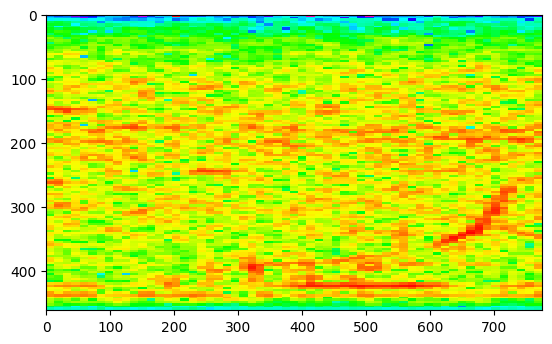

In [38]:
plt.imshow(x_train[0], interpolation='nearest')

Create NN based on Xception NN

In [39]:
size = (150, 150)

train_ds = train_data.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = val_data.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_data.map(lambda x, y: (tf.image.resize(x, size), y))

In [40]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [28]:
# import numpy as np

# for images, labels in train_ds.take(1):
#     plt.figure(figsize=(10, 10))
#     first_image = images[0]
#     plt.imshow(first_image.numpy().astype("int32"))
#     plt.title(int(labels[0]))
#     plt.axis("off")

In [21]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [41]:
# https://keras.io/guides/transfer_learning/

base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [42]:
# Freeze the base_model
base_model.trainable = False

In [43]:
inputs = keras.Input(shape=(150, 150, 3))
x = inputs
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

In [44]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                           

In [45]:
weights_file = 'weights_main.h5'
callback = ModelCheckpoint(weights_file, mode='max', save_best_only=True)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[callback])

Epoch 1/20
750/750 [==============================] - 283s 373ms/step - loss: 0.5207 - binary_accuracy: 0.7726 - val_loss: 1.2369 - val_binary_accuracy: 0.5500
Epoch 2/20
750/750 [==============================] - 261s 348ms/step - loss: 0.5181 - binary_accuracy: 0.7736 - val_loss: 1.2490 - val_binary_accuracy: 0.5500
Epoch 3/20
750/750 [==============================] - 257s 342ms/step - loss: 0.5186 - binary_accuracy: 0.7739 - val_loss: 1.2545 - val_binary_accuracy: 0.5500
Epoch 4/20
750/750 [==============================] - 258s 344ms/step - loss: 0.5182 - binary_accuracy: 0.7730 - val_loss: 1.2496 - val_binary_accuracy: 0.5500
Epoch 5/20
  7/750 [..............................] - ETA: 4:02 - loss: 0.3289 - binary_accuracy: 0.9018

KeyboardInterrupt: 

In [46]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 5
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                           

KeyboardInterrupt: 